# Blue Book for Bulldozers
`Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.`

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

Fast Iron is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.
***
## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float', "{:.4f}".format)

In [2]:
data_dict = pd.read_excel('data/Data Dictionary.xlsx', index_col=0)
def feature_info(feature):
    print(f"{feature.upper()}: {data_dict.loc[feature, 'Description']}")

In [3]:
data = pd.read_csv('data/TrainAndValid.csv', low_memory=False)
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0000,999089,3157,121,3.0000,2004,68.0000,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0000,117657,77,121,3.0000,1996,4640.0000,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0000,434808,7009,121,3.0000,2001,2838.0000,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0000,1026470,332,121,3.0000,2001,3486.0000,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0000,1057373,17311,121,3.0000,2007,722.0000,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
data.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,412698.0000,412698.0000,412698.0000,412698.0000,412698.0000,392562.0000,412698.0000,147504.0000
mean,2011161.1636,31215.1814,1230061.4366,6947.2018,135.1694,6.5853,1899.0496,3522.9883
std,1080067.7245,23141.7437,453953.2579,6280.8250,9.6467,17.1584,292.1902,27169.9286
min,1139246.0000,4750.0000,0.0000,28.0000,121.0000,0.0000,1000.0000,0.0000
25%,1421897.7500,14500.0000,1088593.2500,3261.0000,132.0000,1.0000,1985.0000,0.0000
50%,1645852.5000,24000.0000,1284397.0000,4605.0000,132.0000,2.0000,1995.0000,0.0000
75%,2261012.5000,40000.0000,1478079.2500,8899.0000,136.0000,4.0000,2001.0000,3209.0000
max,6333349.0000,142000.0000,2486330.0000,37198.0000,173.0000,99.0000,2014.0000,2483300.0000


In [6]:
i = 1
missing_50 = []
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum() * 100 / len(data)
        if missing > 50:
            missing_50.append(column)
        print(f"{i}- {column}: Missing Values ===> {missing:.2f}%")
        i += 1

1- auctioneerID: Missing Values ===> 4.88%
2- MachineHoursCurrentMeter: Missing Values ===> 64.26%
3- UsageBand: Missing Values ===> 82.15%
4- fiSecondaryDesc: Missing Values ===> 34.10%
5- fiModelSeries: Missing Values ===> 85.78%
6- fiModelDescriptor: Missing Values ===> 81.87%
7- ProductSize: Missing Values ===> 52.49%
8- Drive_System: Missing Values ===> 74.05%
9- Enclosure: Missing Values ===> 0.08%
10- Forks: Missing Values ===> 52.09%
11- Pad_Type: Missing Values ===> 80.35%
12- Ride_Control: Missing Values ===> 62.99%
13- Stick: Missing Values ===> 80.35%
14- Transmission: Missing Values ===> 54.44%
15- Turbocharged: Missing Values ===> 80.35%
16- Blade_Extension: Missing Values ===> 93.70%
17- Blade_Width: Missing Values ===> 93.70%
18- Enclosure_Type: Missing Values ===> 93.70%
19- Engine_Horsepower: Missing Values ===> 93.70%
20- Hydraulics: Missing Values ===> 20.01%
21- Pushblock: Missing Values ===> 93.70%
22- Ripper: Missing Values ===> 74.09%
23- Scarifier: Missing Valu

In [7]:
len(missing_50)

35

In [8]:
sum(data.isna().sum(axis=1) >= 20)

412698

In [9]:
data.shape

(412698, 53)

We have `35` features with more than `50%` missing values and the all rows have more than `20` missing values.

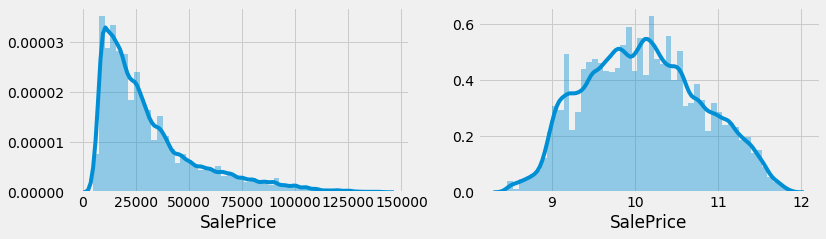

In [10]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
sns.distplot(data.SalePrice, bins=50)

plt.subplot(2, 2, 2)
sns.distplot(np.log(data.SalePrice), bins=50)

In [11]:
col_lst = sorted(data.columns.to_list())

In [12]:
print(col_lst)

['Backhoe_Mounting', 'Blade_Extension', 'Blade_Type', 'Blade_Width', 'Coupler', 'Coupler_System', 'Differential_Type', 'Drive_System', 'Enclosure', 'Enclosure_Type', 'Engine_Horsepower', 'Forks', 'Grouser_Tracks', 'Grouser_Type', 'Hydraulics', 'Hydraulics_Flow', 'MachineHoursCurrentMeter', 'MachineID', 'ModelID', 'Pad_Type', 'Pattern_Changer', 'ProductGroup', 'ProductGroupDesc', 'ProductSize', 'Pushblock', 'Ride_Control', 'Ripper', 'SalePrice', 'SalesID', 'Scarifier', 'Steering_Controls', 'Stick', 'Stick_Length', 'Thumb', 'Tip_Control', 'Tire_Size', 'Track_Type', 'Transmission', 'Travel_Controls', 'Turbocharged', 'Undercarriage_Pad_Width', 'UsageBand', 'YearMade', 'auctioneerID', 'datasource', 'fiBaseModel', 'fiModelDesc', 'fiModelDescriptor', 'fiModelSeries', 'fiProductClassDesc', 'fiSecondaryDesc', 'saledate', 'state']


In [13]:
print(missing_50)

['MachineHoursCurrentMeter', 'UsageBand', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'Drive_System', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']


### Sort DataFrame by saledate

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [14]:
data.saledate.head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

In [15]:
data['saledate'] = pd.to_datetime(data.saledate)

In [16]:
data.sort_values(by=['saledate'], inplace=True)

In [17]:
data.saledate.tail(20)

406079   2012-04-28
409783   2012-04-28
411522   2012-04-28
412218   2012-04-28
411527   2012-04-28
406092   2012-04-28
409780   2012-04-28
406167   2012-04-28
411334   2012-04-28
412164   2012-04-28
409202   2012-04-28
408976   2012-04-28
411695   2012-04-28
411319   2012-04-28
408889   2012-04-28
410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, dtype: datetime64[ns]

In [31]:
data.groupby('saledate').SalePrice.describe()

,count,mean,std,min,25%,50%,75%,max
saledate,,,,,,,,
1989-01-17,1.0000,9500.0000,nan,9500.0000,9500.0000,9500.0000,9500.0000,9500.0000
1989-01-31,97.0000,29932.4742,23107.1238,7700.0000,17000.0000,23000.0000,34000.0000,120000.0000
1989-02-01,492.0000,26366.4634,17815.5260,7500.0000,14500.0000,21500.0000,30500.0000,107000.0000
1989-02-14,18.0000,52472.2222,28888.9722,9000.0000,23250.0000,59000.0000,76125.0000,94000.0000
1989-02-15,31.0000,17374.1935,8074.8980,8250.0000,10500.0000,16000.0000,20000.0000,39000.0000
...,...,...,...,...,...,...,...,...
2012-04-24,121.0000,35028.9256,25270.5607,6500.0000,15000.0000,25000.0000,51000.0000,120000.0000
2012-04-25,139.0000,34653.5971,25737.7139,6500.0000,14800.0000,27500.0000,46500.0000,126000.0000
2012-04-26,62.0000,31532.2581,24729.9962,5000.0000,14250.0000,24000.0000,36500.0000,100000.0000


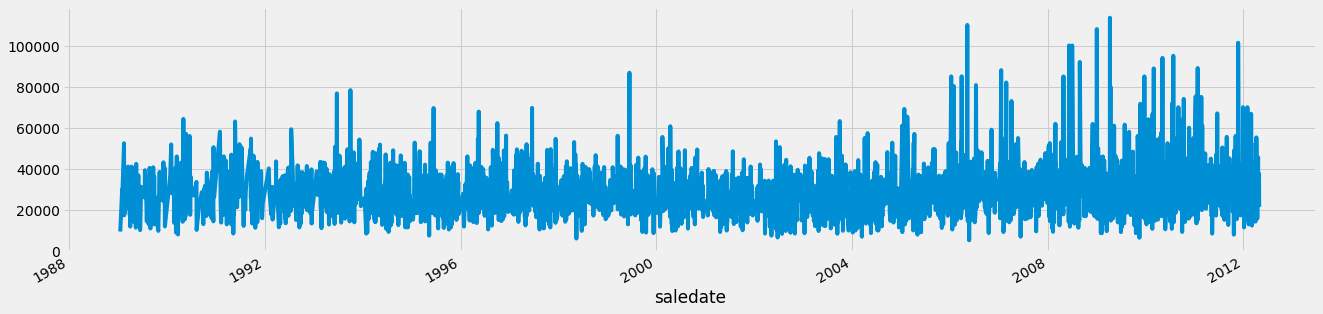

In [34]:
plt.figure(figsize=(20, 5))
data.groupby('saledate').SalePrice.mean().plot()

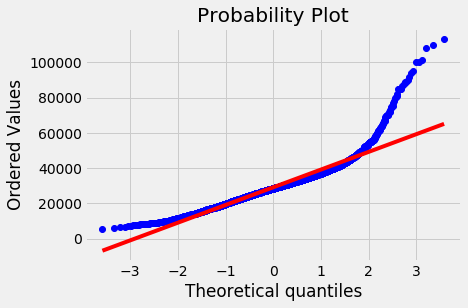

In [36]:
import scipy.stats
import pylab

scipy.stats.probplot(data.groupby('saledate').SalePrice.mean(), plot=pylab);

### Add datetime parameters for saledate column

So we can enrich our dataset with as much information as possible.

In [40]:
data['SaleYear'] = data.saledate.dt.year
data['SaleMonth'] = data.saledate.dt.month
data['SaleDay'] = data.saledate.dt.day
data['SaleDayOfWeek'] = data.saledate.dt.dayofweek
data['SaleDayOfYear'] = data.saledate.dt.dayofyear

In [41]:
data[['saledate', 'SaleYear', 'SaleMonth', 'SaleDay', 'SaleDayOfWeek', 'SaleDayOfYear']]

,saledate,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
205615,1989-01-17,1989,1,17,1,17
274835,1989-01-31,1989,1,31,1,31
141296,1989-01-31,1989,1,31,1,31
212552,1989-01-31,1989,1,31,1,31
62755,1989-01-31,1989,1,31,1,31
...,...,...,...,...,...,...
410879,2012-04-28,2012,4,28,5,119
412476,2012-04-28,2012,4,28,5,119
411927,2012-04-28,2012,4,28,5,119
407124,2012-04-28,2012,4,28,5,119


## Change the dtype object into category

In [42]:
# This will convert object type into category
for label, content in data.items():
    if pd.api.types.is_string_dtype(content):
        data[label] = content.astype("category").cat.as_ordered()

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   category      
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 1

## Filling numeric missing values

In [44]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content) and pd.isnull(content).sum():
        # Add a column that shows if the data was missing
        data[label + '_missing'] = pd.isnull(content)
        data[label].fillna(content.median(), inplace=True)

In [45]:
data[['auctioneerID', 'MachineHoursCurrentMeter']].isna().sum()

auctioneerID                0
MachineHoursCurrentMeter    0
dtype: int64

In [46]:
data.MachineHoursCurrentMeter.value_counts()

0.0000        339028
2000.0000        124
1000.0000        117
24.0000          115
1500.0000        101
               ...  
6485.0000          1
25933.0000         1
25931.0000         1
12963.0000         1
27548.0000         1
Name: MachineHoursCurrentMeter, Length: 15633, dtype: int64

## Filling categorical missing values

In [47]:
for label, content in data.items():
    if not pd.api.types.is_numeric_dtype(content):
        data[label + '_missing'] = pd.isnull(content)
        data[label] = pd.Categorical(content).codes + 1
#         data[label].fillna(content.median(), inplace=True)

In [48]:
i = 1
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum() * 100 / len(data)
        print(f"{i}- {column}: Missing Values ===> {missing:.2f}%")
        i += 1

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 105 entries, SalesID to Steering_Controls_missing
dtypes: bool(47), float64(3), int16(5), int64(10), int8(40)
memory usage: 82.3 MB


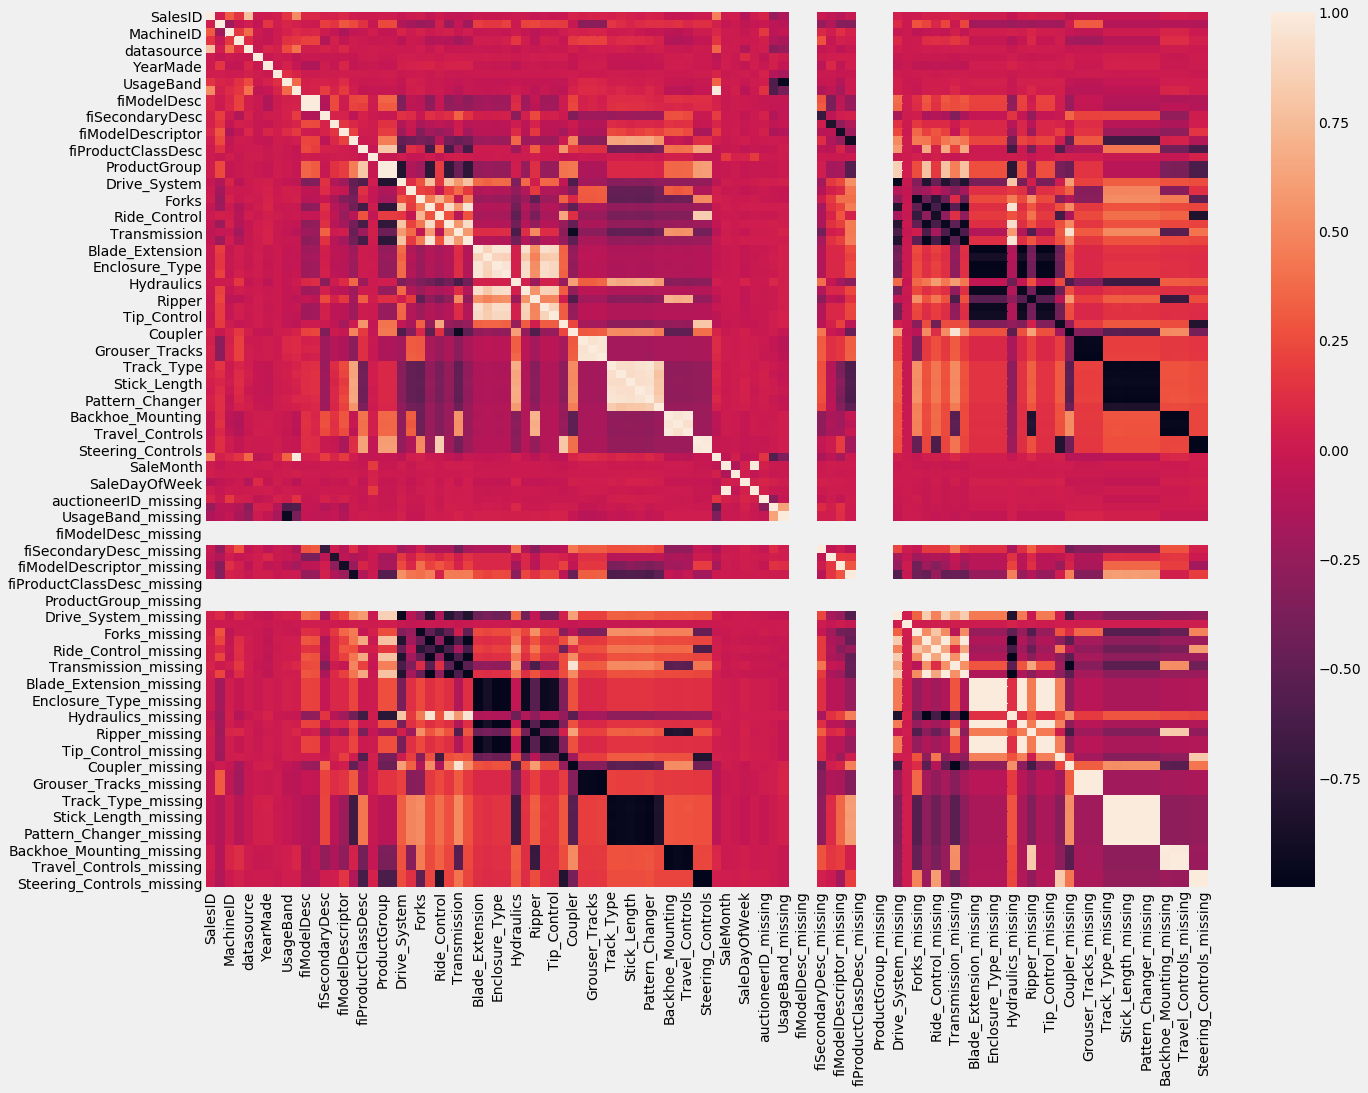

In [50]:
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr())

In [51]:
data.drop(['saledate'], axis=1, inplace=True)

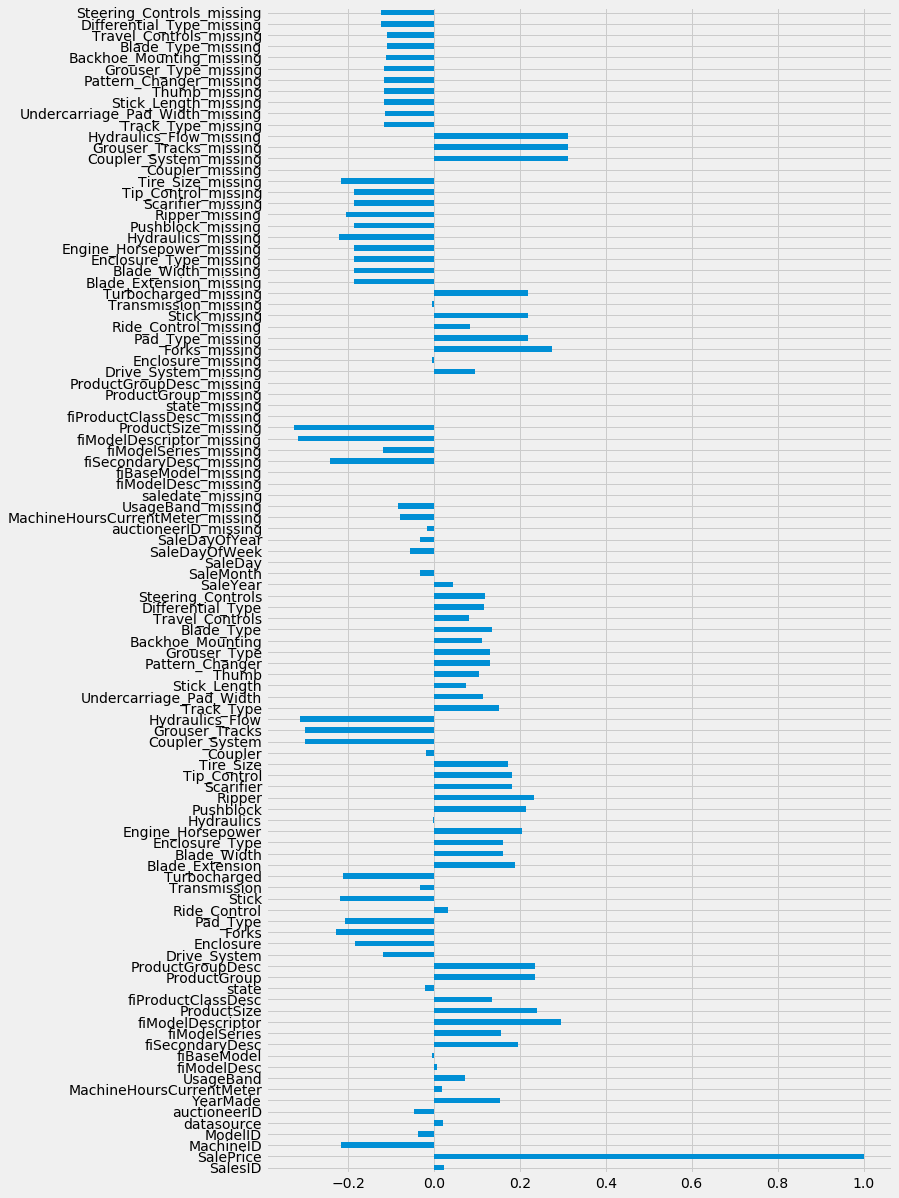

In [52]:
data.corr().SalePrice.plot(kind='barh', figsize=(10, 20))

In [53]:
from sklearn.ensemble import RandomForestRegressor

X = data.drop('SalePrice', axis=1)
y = data.SalePrice

rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

%time
rf_model.fit(X, y)

Wall time: 0 ns


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [54]:
rf_model.score(X, y)

0.9875949008627203

# Train Test Split

In [58]:
rf_model= data[data.SaleYear < 2012]
test = data[data.SaleYear >= 2012]

print(train.shape)
print(test.shape)

(401125, 104)
(11573, 104)


In [59]:
X_train = train.drop('SalePrice', axis=1)
y_train = train.SalePrice
X_test = test.drop('SalePrice', axis=1)
y_test = test.SalePrice

In [66]:
rf_model = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
rf_model.score(X_test, y_test)

0.8733629521290419

In [68]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("===============TRAIN SCORE=================")
print(f"ROOT MEAN SQUARE LOG ERROR: {np.sqrt(mean_squared_log_error(y_train, y_train_pred))}")
print(f"MEAN ABSOLUTE ERROR: {mean_absolute_error(y_train, y_train_pred)}")

print("================TEST SCORE=================")
print(f"ROOT MEAN SQUARE LOG ERROR: {np.sqrt(mean_squared_log_error(y_test, y_test_pred))}")
print(f"MEAN ABSOLUTE ERROR: {mean_absolute_error(y_test, y_test_pred)}")

===============TRAIN SCORE=================
ROOT MEAN SQUARE LOG ERROR: 0.08420988754610995
MEAN ABSOLUTE ERROR: 1579.309419607354
================TEST SCORE=================
ROOT MEAN SQUARE LOG ERROR: 0.2544297300144517
MEAN ABSOLUTE ERROR: 6108.353368184567


In [69]:
data.SalePrice.mean()

31215.181414012186

Our model can predict the `SalePrice` with a gap of `+/- 6108$`

## XGBoost Regressor

In [72]:
from xgboost import XGBRFRegressor

xgb_model = XGBRFRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [73]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

print("===============TRAIN SCORE=================")
print(f"ROOT MEAN SQUARE LOG ERROR: {np.sqrt(mean_squared_log_error(y_train, y_train_pred))}")
print(f"MEAN ABSOLUTE ERROR: {mean_absolute_error(y_train, y_train_pred)}")

print("================TEST SCORE=================")
print(f"ROOT MEAN SQUARE LOG ERROR: {np.sqrt(mean_squared_log_error(y_test, y_test_pred))}")
print(f"MEAN ABSOLUTE ERROR: {mean_absolute_error(y_test, y_test_pred)}")

===============TRAIN SCORE=================
ROOT MEAN SQUARE LOG ERROR: 0.5020359644819798
MEAN ABSOLUTE ERROR: 11739.50730275446
================TEST SCORE=================
ROOT MEAN SQUARE LOG ERROR: 0.5057791390078693
MEAN ABSOLUTE ERROR: 13300.781097030806
